# Box Office Revenue Prediction

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [22]:
df= pd.read_csv("/content/boxoffice.csv")

df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [23]:
df.shape

(2694, 10)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,7.673272e+07,152572473.5,2.247314e+08,2.998107e+08
world_revenue,2694.0,7.719177e+08,4.284414e+08,3261301.0,3.991135e+08,766555142.5,1.143920e+09,1.499310e+09
opening_revenue,2694.0,9.971321e+07,5.721762e+07,138569.0,5.033848e+07,99814175.0,1.489805e+08,1.999336e+08
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1.161000e+03,2271.5,3.392250e+03,4.499000e+03
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,7.861876e+07,156256716.0,2.274832e+08,2.998597e+08
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,4.700000e+01,91.0,1.350000e+02,1.790000e+02


In [26]:
df.columns

Index(['title', 'domestic_revenue', 'world_revenue', 'distributor',
       'opening_revenue', 'opening_theaters', 'budget', 'MPAA', 'genres',
       'release_days'],
      dtype='object')

In [27]:
to_remove_col = ['world_revenue', 'opening_revenue']

df.drop(to_remove_col, axis=1, inplace=True)

In [28]:
df.isnull().sum()

,0
title,0
domestic_revenue,0
distributor,0
opening_theaters,0
budget,0
MPAA,0
genres,0
release_days,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   distributor       2694 non-null   object
 3   opening_theaters  2694 non-null   int64 
 4   budget            2694 non-null   int64 
 5   MPAA              2694 non-null   object
 6   genres            2694 non-null   object
 7   release_days      2694 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 168.5+ KB


In [30]:
df['domestic_revenue'] = pd.to_numeric(df['domestic_revenue'], errors="coerce")

In [36]:
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()

obj_cols.remove("title")

In [37]:
obj_cols

['distributor', 'MPAA', 'genres']

In [38]:
encoders = {}

for col in obj_cols:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  encoders[col] = le


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   distributor       2694 non-null   int64 
 3   opening_theaters  2694 non-null   int64 
 4   budget            2694 non-null   int64 
 5   MPAA              2694 non-null   int64 
 6   genres            2694 non-null   int64 
 7   release_days      2694 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 168.5+ KB


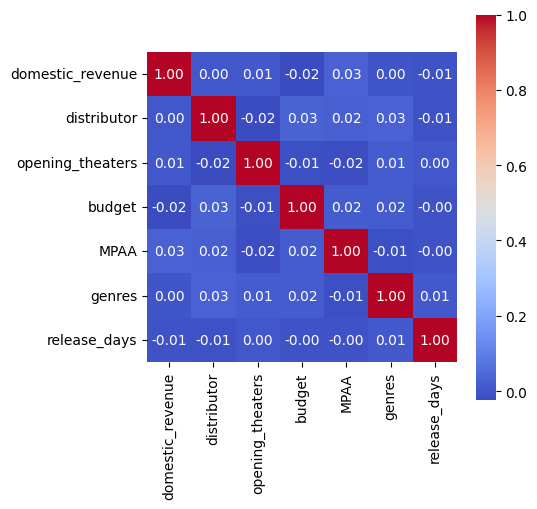

In [70]:
plt.figure(figsize=(5,5))
sns.heatmap(df.drop(["title"],axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f" , square=True)
plt.show()

In [71]:
target = "domestic_revenue"

In [72]:
df.drop(["title"],axis=1).corr()[target].drop([target])

,domestic_revenue
distributor,0.001980
opening_theaters,0.006666
budget,-0.021222
MPAA,0.027604
genres,0.000859
release_days,-0.005884


In [73]:
X = df.drop(["title", target, "genres", 'release_days'], axis=1)
y = df[target]

X_train, X_test, y_train, y_test, =train_test_split(X, y, test_size=0.3, random_state=13)

In [74]:
from scipy.stats import skew

skew(pd.Series(y))

np.float64(-0.028371644445010762)

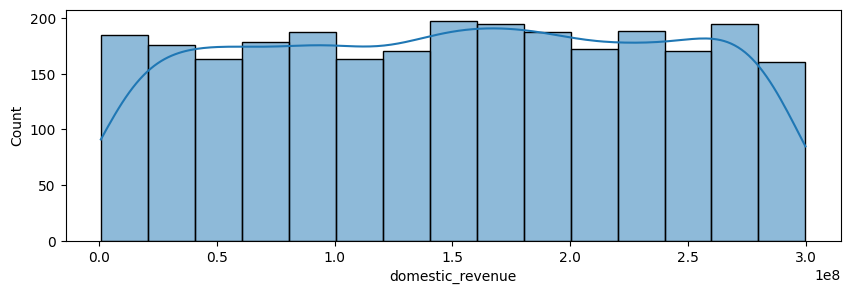

In [75]:
plt.figure(figsize=(10,3))

sns.histplot(pd.Series(y), kde=True)

plt.show()

In [76]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [77]:
model = XGBRegressor()

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [79]:
train_error = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
test_error = metrics.mean_absolute_percentage_error(y_test, y_pred)

In [80]:
train_error, test_error

(0.013492154621972159, 0.047260720778308805)

# no major overfitting!